In [126]:
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import yfinance as yf
from finta import TA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate
from ta import add_all_ta_features

In [127]:
WINDOW = 16  # number of rows to look ahead to see what the price did
FETCH_INTERVAL = "60m"  # fetch data by interval (including intraday if period < 60 days)
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# (optional, default is '1d')
INTERVAL = '1y'  # use "period" instead of start/end
# valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# (optional, default is '1mo')
symbol = 'AAPL'  # Symbol of the desired stock
ROWS_TO_PREDICT = 128
# one day 16 rows of data

In [128]:
data = pd.read_csv(
    'C:\\Users\\exomat\\Desktop\\repo\\magisterka_analiza\\data\\preprocess\\APPLE_22_03_2021 21_56_34.csv')



In [129]:
data.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
data.head(10)

,open,high,low,close,Adj Close,volume
0,56.220000,56.220000,55.500000,55.600000,55.600000,0
1,55.550000,56.095000,55.370000,55.700000,55.700000,0
2,56.032500,56.437500,55.937500,56.247500,56.247500,0
3,56.132500,56.750000,56.042500,56.595000,56.595000,0
4,56.550000,58.197500,55.625000,57.812500,57.812500,0
5,57.837500,59.525000,56.887500,57.020000,57.020000,0
6,56.299999,56.750000,54.823750,55.450001,55.450001,21473989
7,55.465000,55.889999,53.412498,53.767502,53.767502,11306818
8,53.762501,55.097500,53.152500,54.803925,54.803925,11355189
9,54.823875,56.775002,54.472500,55.486252,55.486252,10671797


<AxesSubplot:>

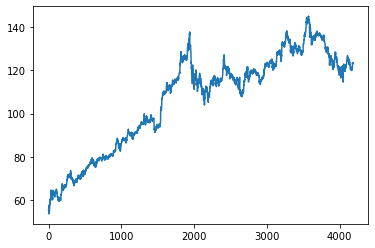

In [130]:
data['close'].plot()

In [131]:
data['close_pct'] = data['close'].pct_change()
data.head()

,open,high,low,close,Adj Close,volume,close_pct
0,56.2200,56.2200,55.5000,55.6000,55.6000,0,NaN
1,55.5500,56.0950,55.3700,55.7000,55.7000,0,0.001799
2,56.0325,56.4375,55.9375,56.2475,56.2475,0,0.009829
3,56.1325,56.7500,56.0425,56.5950,56.5950,0,0.006178
4,56.5500,58.1975,55.6250,57.8125,57.8125,0,0.021513


In [132]:
data.describe()

,open,high,low,close,Adj Close,volume,close_pct
count,4183.000000,4183.000000,4183.000000,4183.000000,4183.000000,4.183000e+03,4182.000000
mean,106.643887,107.166827,106.048708,106.644971,106.644971,4.714023e+06,0.000208
std,22.417863,23.119607,22.318330,22.402033,22.402033,8.307361e+06,0.005948
min,53.762501,55.097500,50.978220,53.767502,53.767502,0.000000e+00,-0.051319
25%,88.078750,88.337500,87.816251,88.085000,88.085000,0.000000e+00,-0.002029
50%,114.907500,115.240000,114.200000,114.900000,114.900000,0.000000e+00,0.000164
75%,123.514999,124.200000,122.829999,123.482502,123.482502,7.035940e+06,0.002525
max,144.900000,438.440000,144.590000,144.910000,144.910000,9.845401e+07,0.051457


In [133]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    data = add_all_ta_features(
        data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

    # Instead of using the actual volume value (which changes over time), we normalize it with a moving volume average
    # data['normVol'] = data['volume'] / data['volume'].ewm(5).mean()
    # for i in range(1,50):
    #     data[f'close{i}'] = data['close'].shift(i)
    # Remove columns that won't be used as features
    # del (data['Adj Close'])

    return data


In [134]:
data

,open,high,low,close,Adj Close,volume,close_pct
0,56.220000,56.220000,55.500000,55.600000,55.600000,0,NaN
1,55.550000,56.095000,55.370000,55.700000,55.700000,0,0.001799
2,56.032500,56.437500,55.937500,56.247500,56.247500,0,0.009829
3,56.132500,56.750000,56.042500,56.595000,56.595000,0,0.006178
4,56.550000,58.197500,55.625000,57.812500,57.812500,0,0.021513
...,...,...,...,...,...,...,...
4178,123.425003,123.769997,123.040001,123.091103,123.091103,12373575,-0.002746
4179,123.090103,123.720001,123.080002,123.542000,123.542000,9430925,0.003663
4180,123.544998,123.870003,123.275002,123.345001,123.345001,11354023,-0.001595
4181,123.339996,123.599998,123.019997,123.370003,123.370003,10684835,0.000203


In [135]:
data.columns

Index(['open', 'high', 'low', 'close', 'Adj Close', 'volume', 'close_pct'], dtype='object')

In [136]:
def create_class_column(row, lowest_threshold, higher_threshold):
    if row['close_shift'] - row['close'] > higher_threshold:
        return 1
    if row['close_shift'] - row['close'] < lowest_threshold:
        return -1
    else:
        return 0

In [137]:
data['close_shift'] = data.shift(-WINDOW)['close']
data

,open,high,low,close,Adj Close,volume,close_pct,close_shift
0,56.220000,56.220000,55.500000,55.600000,55.600000,0,NaN,56.8750
1,55.550000,56.095000,55.370000,55.700000,55.700000,0,0.001799,58.4475
2,56.032500,56.437500,55.937500,56.247500,56.247500,0,0.009829,58.5500
3,56.132500,56.750000,56.042500,56.595000,56.595000,0,0.006178,59.2225
4,56.550000,58.197500,55.625000,57.812500,57.812500,0,0.021513,58.3075
...,...,...,...,...,...,...,...,...
4178,123.425003,123.769997,123.040001,123.091103,123.091103,12373575,-0.002746,NaN
4179,123.090103,123.720001,123.080002,123.542000,123.542000,9430925,0.003663,NaN
4180,123.544998,123.870003,123.275002,123.345001,123.345001,11354023,-0.001595,NaN
4181,123.339996,123.599998,123.019997,123.370003,123.370003,10684835,0.000203,NaN


In [138]:
higher_threshold = 1.5
lowest_threshold = -1.5
last_values_higher = []
last_values_lower = []
data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)
while True:
    print(data['class_column'].value_counts())
    class_counts = data['class_column'].value_counts()
    if abs(class_counts[0] - class_counts[1]) < 15 and abs(class_counts[0] - class_counts[-1]) < 15:
        break

    if len(last_values_higher) == 3:
        last_values_higher.pop(0)
    if len(last_values_lower) == 3:
        last_values_lower.pop(0)

    last_values_higher.append(higher_threshold)
    last_values_lower.append(lowest_threshold)
    if class_counts[0] > class_counts[1]:
        higher_threshold -= 0.01
    if class_counts[0] > class_counts[-1]:
        lowest_threshold += 0.01
    if class_counts[0] < class_counts[1]:
        higher_threshold += 0.01
    if class_counts[0] < class_counts[-1]:
        lowest_threshold -= 0.01

    if higher_threshold in last_values_higher and lowest_threshold in last_values_lower:
        break
    print(higher_threshold, lowest_threshold)
    data['class_column'] = data.apply((lambda x: create_class_column(x, lowest_threshold, higher_threshold)), axis=1)

data

 0    2289
 1    1105
-1     789
Name: class_column, dtype: int64
1.49 -1.49
 0    2276
 1    1114
-1     793
Name: class_column, dtype: int64
1.48 -1.48
 0    2262
 1    1119
-1     802
Name: class_column, dtype: int64
1.47 -1.47
 0    2248
 1    1128
-1     807
Name: class_column, dtype: int64
1.46 -1.46
 0    2234
 1    1136
-1     813
Name: class_column, dtype: int64
1.45 -1.45
 0    2226
 1    1137
-1     820
Name: class_column, dtype: int64
1.44 -1.44
 0    2220
 1    1141
-1     822
Name: class_column, dtype: int64
1.43 -1.43
 0    2211
 1    1149
-1     823
Name: class_column, dtype: int64
1.42 -1.42
 0    2197
 1    1155
-1     831
Name: class_column, dtype: int64
1.41 -1.41
 0    2186
 1    1161
-1     836
Name: class_column, dtype: int64
1.4 -1.4
 0    2177
 1    1167
-1     839
Name: class_column, dtype: int64
1.39 -1.39
 0    2163
 1    1176
-1     844
Name: class_column, dtype: int64
1.38 -1.38
 0    2152
 1    1180
-1     851
Name: class_column, dtype: int64
1.3699999999

,open,high,low,close,Adj Close,volume,close_pct,close_shift,class_column
0,56.220000,56.220000,55.500000,55.600000,55.600000,0,NaN,56.8750,1
1,55.550000,56.095000,55.370000,55.700000,55.700000,0,0.001799,58.4475,1
2,56.032500,56.437500,55.937500,56.247500,56.247500,0,0.009829,58.5500,1
3,56.132500,56.750000,56.042500,56.595000,56.595000,0,0.006178,59.2225,1
4,56.550000,58.197500,55.625000,57.812500,57.812500,0,0.021513,58.3075,0
...,...,...,...,...,...,...,...,...,...
4178,123.425003,123.769997,123.040001,123.091103,123.091103,12373575,-0.002746,NaN,0
4179,123.090103,123.720001,123.080002,123.542000,123.542000,9430925,0.003663,NaN,0
4180,123.544998,123.870003,123.275002,123.345001,123.345001,11354023,-0.001595,NaN,0
4181,123.339996,123.599998,123.019997,123.370003,123.370003,10684835,0.000203,NaN,0


In [139]:
# Class divide
data['class_column'].value_counts()

 1    1399
 0    1396
-1    1388
Name: class_column, dtype: int64

In [140]:
data = _get_indicator_data(data)
data

C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\exomat\anaconda3\envs\magisterka_analiza\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,open,high,low,close,volume,close_pct,close_shift,class_column,volume_adi,volume_obv,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
0,56.220000,56.220000,55.500000,55.600000,0,NaN,56.8750,1,-0.000000e+00,0,...,-86.111111,0.000000,55.600000,0.000000,0.000000,0.000000,0.000000,-47.864396,0.000000,0.000000
1,55.550000,56.095000,55.370000,55.700000,0,0.001799,58.4475,1,-0.000000e+00,0,...,-61.176471,0.000000,55.641486,0.000000,0.000000,0.000000,0.000000,0.179856,0.179695,0.179856
2,56.032500,56.437500,55.937500,56.247500,0,0.009829,58.5500,1,0.000000e+00,0,...,-17.798595,0.000000,55.895109,0.000000,0.000000,0.000000,0.000000,0.982944,0.978145,1.164568
3,56.132500,56.750000,56.042500,56.595000,0,0.006178,59.2225,1,0.000000e+00,0,...,-11.231884,0.000000,56.185689,0.000000,0.000000,0.000000,0.000000,0.617805,0.615905,1.789568
4,56.550000,58.197500,55.625000,57.812500,0,0.021513,58.3075,0,0.000000e+00,0,...,-13.616269,0.000000,56.833695,0.000000,0.000000,0.000000,0.000000,2.151250,2.128437,3.979317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4178,123.425003,123.769997,123.040001,123.091103,12373575,-0.002746,NaN,0,6.772166e+08,-304635341,...,-5.788523,1.307150,122.417025,2.550281,17.274375,-5.237322,22.511697,-0.274567,-0.274944,121.386875
4179,123.090103,123.720001,123.080002,123.542000,9430925,0.003663,NaN,0,6.814015e+08,-295204416,...,-1.943993,1.853018,122.683125,2.960247,17.006940,-0.788469,17.795410,0.366312,0.365642,122.197841
4180,123.544998,123.870003,123.275002,123.345001,11354023,-0.001595,NaN,0,6.727190e+08,-306558439,...,-13.392887,2.216141,122.806622,2.770373,18.299709,3.029166,15.270543,-0.159459,-0.159586,121.843527
4181,123.339996,123.599998,123.019997,123.370003,10684835,0.000203,NaN,0,6.749298e+08,-295873604,...,-12.755093,2.310367,122.908690,2.119032,18.355886,6.094510,12.261375,0.020270,0.020268,121.888494


In [141]:
filename_to_export = f'../data/preprocess/{symbol}_{WINDOW}_{ datetime.now().strftime("%d_%m_%Y %H_%M_%S")}_full.csv'
data.to_csv(filename_to_export)